# Reconstruction of feature 'GEBURTSJAHR' (year of birth)
**Objective:**

* The objective is to reconstruct the feature *'GEBURTSJAHR'*

**Idea:**

* Use IterativeImputer
* Select candidates from the most correlated and anti correlated features 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from common_functions import load_dataframe, save_dataframe

from featureengineering import PreProcessor

from time import time
import datetime
import joblib 


# magic word for producing visualizations in notebook
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

sns.set_theme()

## Load Data

In [2]:
root_path='.'
out_dirname = 'tmp_results'

In [3]:
#customers = load_dataframe(f'{root_path}/tmp_dat_explore/pre_processor/03_df_customers_missing.h5')
#azdias = load_dataframe(f'{root_path}/tmp_dat_explore/pre_processor/03_df_azdias_missing.h5')
#PreProcessor(root_path=root_path, out_dir=out_dirname)

In [4]:
%%time

azdias, customers = PreProcessor(root_path=root_path, out_dir=out_dirname).load_step_3_missing_handled_dfs()[0:2]

Wall time: 6.1 s


## Check most correlated and anti correlated features

For the features 'GEBURTSJAHR' and 'ALTERSKATEGORIE_FEIN' we look for the features having the highest potisitve and negative correlation.

In [5]:
%%time
corr_geb_jahr = {}
corr_akf = {}
for col in azdias.columns:
    corr_geb_jahr[col]=azdias['GEBURTSJAHR'].corr(azdias[col])
    corr_akf[col]=azdias['ALTERSKATEGORIE_FEIN'].corr(azdias[col])

Wall time: 22.7 s


In [6]:
series_geburts_jahr=pd.Series(corr_geb_jahr)
series_geburts_jahr.sort_values(ascending=False)[:9]

GEBURTSJAHR              1.000000
ALTERSKATEGORIE_FEIN     0.996867
FINANZ_SPARER            0.868574
CJT_TYP_1                0.818511
CJT_TYP_2                0.810543
FINANZ_UNAUFFAELLIGER    0.741226
FINANZ_ANLEGER           0.731116
RT_KEIN_ANREIZ           0.604106
SEMIO_PFLICHT            0.523703
dtype: float64

In [7]:
series_geburts_jahr.sort_values(ascending=True)[:9]

KOMBIALTER             -0.932395
FINANZ_VORSORGER       -0.770304
CJT_TYP_3              -0.747213
CJT_TYP_5              -0.724432
CJT_TYP_4              -0.717640
ALTERSKATEGORIE_GROB   -0.592449
CJT_TYP_6              -0.580871
FINANZ_MINIMALIST      -0.542958
RETOURTYP_BK_S         -0.541516
dtype: float64

In [8]:
series_alterskat_fein = pd.Series(corr_akf)
series_alterskat_fein.sort_values(ascending=False)[:9]

ALTERSKATEGORIE_FEIN     1.000000
GEBURTSJAHR              0.996867
FINANZ_SPARER            0.862535
CJT_TYP_1                0.828270
CJT_TYP_2                0.816176
FINANZ_UNAUFFAELLIGER    0.732906
FINANZ_ANLEGER           0.730858
RT_KEIN_ANREIZ           0.598343
SEMIO_PFLICHT            0.521948
dtype: float64

In [9]:
series_alterskat_fein.sort_values(ascending=True)[:9]

KOMBIALTER             -0.922162
FINANZ_VORSORGER       -0.777683
CJT_TYP_3              -0.764950
CJT_TYP_4              -0.740935
CJT_TYP_5              -0.739669
CJT_TYP_6              -0.601607
ALTERSKATEGORIE_GROB   -0.589081
RETOURTYP_BK_S         -0.545208
FINANZ_MINIMALIST      -0.524314
dtype: float64

### Check null value ratio in the candidate columns

In [10]:
impute_cols = ['ALTERSKATEGORIE_FEIN',
                'FINANZ_SPARER',
                'GEBURTSJAHR',
                'KOMBIALTER',
                'FINANZ_SPARER',
                'CJT_TYP_1',
                'CJT_TYP_2',
                'CJT_TYP_3',
                'CJT_TYP_4',
                'CJT_TYP_5',
                'CJT_TYP_6',
                'ALTERSKATEGORIE_GROB',
                'FINANZ_VORSORGER']
for col in impute_cols:
    print(f"{col} {100*(azdias[col].isnull().sum()/azdias.shape[0])}")

ALTERSKATEGORIE_FEIN 34.12565457950385
FINANZ_SPARER 0.0
GEBURTSJAHR 44.02028228688507
KOMBIALTER 10.512992849136186
FINANZ_SPARER 0.0
CJT_TYP_1 0.5446460529992
CJT_TYP_2 0.5446460529992
CJT_TYP_3 0.5446460529992
CJT_TYP_4 0.5446460529992
CJT_TYP_5 0.5446460529992
CJT_TYP_6 0.5446460529992
ALTERSKATEGORIE_GROB 0.0
FINANZ_VORSORGER 0.0


## Determine the used columns for imputation

we will choose the features for reconstrtuction by trying. 

In [5]:
%%time

#GEBURTSJAHR                    1.000000
#ALTERSKATEGORIE_FEIN           0.996867
#FINANZ_SPARER                  0.868574
#CJT_TYP_1                      0.818511
#CJT_TYP_2                      0.810543
#FINANZ_UNAUFFAELLIGER          0.741226
#FINANZ_ANLEGER                 0.731116
#RT_KEIN_ANREIZ                 0.604106
#dtype: float64

#KOMBIALTER             -0.932395
#FINANZ_VORSORGER       -0.770304
#CJT_TYP_3              -0.747213
#CJT_TYP_5              -0.724432
#CJT_TYP_4              -0.717640
#ALTERSKATEGORIE_GROB   -0.592449
#CJT_TYP_6              -0.580871
#FINANZ_MINIMALIST      -0.542958
#RETOURTYP_BK_S         -0.541516
test_df_3 = azdias[['ALTERSKATEGORIE_FEIN',
                  #'PRAEGENDE_JUGENDJAHRE_EPOCH',
                  'GEBURTSJAHR',
                  'KOMBIALTER',
                  #'FINANZ_SPARER',
                  'CJT_TYP_1',
                  'CJT_TYP_2',
                  #'FINANZ_VORSORGER',
                   ]].copy(deep=True)
df_metrics_3=test_df_3.describe()
test_df_3['KOMBIALTER'] = test_df_3['KOMBIALTER'].replace(9.0,np.nan)

Wall time: 335 ms


The best results were found using **'ALTERSKATEGORIE_FEIN', 'KOMBIALTER', 'CJT_TYP_1', 'CJT_TYP_2'** for the reconstruction of 'GEBURTSJAHR'.
The decision based on the following criterions:
* The comparison of histograms
    * among each aother
    * before/after comparison
* DataFrame statistics:
    * Mean
    * Standatrd Deviation
    * Min
    * 25% percentile
    * Median
    * 75% percentile
    * Max
    
### IterativeImputer (Bayesian ridge, imputation_order=descending, initial_strategy=median)

In [14]:
%%time
filename=f'{root_path}/birth-reco/geb_dat_imp_bay_med_desc.joblib'
imputer = None
try:
    with open(filename, 'rb') as rf:
        imputer = joblib.load(rf)
except:
    imputer = IterativeImputer(max_iter=10,
                           random_state=0, 
                           imputation_order='descending',
                           sample_posterior=True,
                           skip_complete=True,
                           min_value=df_metrics_3.loc['min', :],
                           max_value=df_metrics_3.loc['max', :],
                           initial_strategy='median',
                           tol=0.001,
                           verbose=2)
    imputer.fit(test_df_3)
    with open(filename, 'wb') as wf:
        joblib.dump(imputer, wf)
        
test_result = None
test_result = pd.DataFrame(data=imputer.transform(test_df_3), index=test_df_3.index, columns=test_df_3.columns)
# save
test_result.reset_index().to_hdf(f'{root_path}/birth-reco/test_result_bay_med_desc.h5', key='df', mode='w', index=False)

[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 66.89
[IterativeImputer] Ending imputation round 2/10, elapsed time 131.61
[IterativeImputer] Ending imputation round 3/10, elapsed time 199.53
[IterativeImputer] Ending imputation round 4/10, elapsed time 267.32
[IterativeImputer] Ending imputation round 5/10, elapsed time 334.29
[IterativeImputer] Ending imputation round 6/10, elapsed time 402.96
[IterativeImputer] Ending imputation round 7/10, elapsed time 470.55
[IterativeImputer] Ending imputation round 8/10, elapsed time 532.79
[IterativeImputer] Ending imputation round 9/10, elapsed time 589.25
[IterativeImputer] Ending imputation round 10/10, elapsed time 672.23
Wall time: 11min 12s


### IterativeImputer (Bayesian ridge, imputation_order=ascending, initial_strategy=median)

In [16]:
%%time
filename=f'{root_path}/birth-reco/geb_dat_imp_bay_med_asc.joblib'
imputer = None
try:
    with open(filename, 'rb') as rf:
        imputer = joblib.load(rf)
except:
    imputer = IterativeImputer(max_iter=10,
                           random_state=0, 
                           imputation_order='ascending',
                           sample_posterior=True,
                           skip_complete=True,
                           min_value=df_metrics_3.loc['min', :],
                           max_value=df_metrics_3.loc['max', :],
                           initial_strategy='median',
                           tol=0.001,
                           verbose=2)
    imputer.fit(test_df_3)
    with open(filename, 'wb') as wf:
        joblib.dump(imputer, wf)
 
test_result = None
test_result = pd.DataFrame(data=imputer.transform(test_df_3), index=test_df_3.index, columns=test_df_3.columns)
# save
test_result.reset_index().to_hdf(f'{root_path}/birth-reco/test_result_bay_med_asc.h5', key='df', mode='w', index=False)

[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 73.24
[IterativeImputer] Ending imputation round 2/10, elapsed time 138.31
[IterativeImputer] Ending imputation round 3/10, elapsed time 200.11
[IterativeImputer] Ending imputation round 4/10, elapsed time 259.20
[IterativeImputer] Ending imputation round 5/10, elapsed time 342.74
[IterativeImputer] Ending imputation round 6/10, elapsed time 451.74
[IterativeImputer] Ending imputation round 7/10, elapsed time 580.28
[IterativeImputer] Ending imputation round 8/10, elapsed time 685.97
[IterativeImputer] Ending imputation round 9/10, elapsed time 781.75
[IterativeImputer] Ending imputation round 10/10, elapsed time 844.57
[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 54.03
[IterativeImputer] Ending imputation round 2/10, elapsed time 103.52
[IterativeImputer] Ending imputation round 3/10, elap

### IterativeImputer (Bayesian ridge, imputation_order=descending, initial_strategy=mean)

In [18]:
%%time
filename=f'{root_path}/birth-reco/geb_dat_imp_bay_mean_desc.joblib'
imputer = None
try:
    with open(filename, 'rb') as rf:
        imputer = joblib.load(rf)
except:
    imputer = IterativeImputer(max_iter=10,
                           random_state=0, 
                           imputation_order='descending',
                           sample_posterior=True,
                           skip_complete=True,
                           min_value=df_metrics_3.loc['min', :],
                           max_value=df_metrics_3.loc['max', :],
                           initial_strategy='mean',
                           tol=0.001,
                           verbose=2)
    imputer.fit(test_df_3)
    with open(filename, 'wb') as wf:
        joblib.dump(imputer, wf)
  
test_result = None
test_result = pd.DataFrame(data=imputer.transform(test_df_3), index=test_df_3.index, columns=test_df_3.columns)
# save
test_result.reset_index().to_hdf(f'{root_path}/birth-reco/test_result_bay_mean_desc.h5', key='df', mode='w', index=False)

[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 53.96
[IterativeImputer] Ending imputation round 2/10, elapsed time 108.21
[IterativeImputer] Ending imputation round 3/10, elapsed time 160.51
[IterativeImputer] Ending imputation round 4/10, elapsed time 212.45
[IterativeImputer] Ending imputation round 5/10, elapsed time 264.02
[IterativeImputer] Ending imputation round 6/10, elapsed time 316.57
[IterativeImputer] Ending imputation round 7/10, elapsed time 369.05
[IterativeImputer] Ending imputation round 8/10, elapsed time 421.74
[IterativeImputer] Ending imputation round 9/10, elapsed time 474.12
[IterativeImputer] Ending imputation round 10/10, elapsed time 527.24
[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 50.16
[IterativeImputer] Ending imputation round 2/10, elapsed time 100.07
[IterativeImputer] Ending imputation round 3/10, elap

### IterativeImputer (Bayesian ridge, imputation_order=ascending, initial_strategy=mean)

In [6]:
%%time
filename=f'{root_path}/birth-reco/geb_dat_imp_bay_mean_asc.joblib'
imputer = None
try:
    with open(filename, 'rb') as rf:
        imputer = joblib.load(rf)
except:
    imputer = IterativeImputer(max_iter=10,
                           random_state=0, 
                           imputation_order='ascending',
                           sample_posterior=True,
                           skip_complete=True,
                           min_value=df_metrics_3.loc['min', :],
                           max_value=df_metrics_3.loc['max', :],
                           initial_strategy='mean',
                           tol=0.001,
                           verbose=2)
    imputer.fit(test_df_3)
    with open(filename, 'wb') as wf:
        joblib.dump(imputer, wf)
    
test_result = None
test_result = pd.DataFrame(data=imputer.transform(test_df_3), index=test_df_3.index, columns=test_df_3.columns)
# save
test_result.reset_index().to_hdf(f'{root_path}/birth-reco/test_result_bay_mean_asc.h5', key='df', mode='w', index=False)

[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 96.30
[IterativeImputer] Ending imputation round 2/10, elapsed time 188.99
[IterativeImputer] Ending imputation round 3/10, elapsed time 282.73
[IterativeImputer] Ending imputation round 4/10, elapsed time 348.19
[IterativeImputer] Ending imputation round 5/10, elapsed time 398.13
[IterativeImputer] Ending imputation round 6/10, elapsed time 449.03
[IterativeImputer] Ending imputation round 7/10, elapsed time 500.08
[IterativeImputer] Ending imputation round 8/10, elapsed time 550.03
[IterativeImputer] Ending imputation round 9/10, elapsed time 599.63
[IterativeImputer] Ending imputation round 10/10, elapsed time 651.44
Wall time: 10min 51s


### Experiment1: IterativeImputer without the CJT_TYPE_... features
* we have IterativeImputer (Bayesian ridge, imputation_order=ascending, initial_strategy=mean)
* here we try to omit the Customer Journey Type FEATURES CJT_TYPE...

In [8]:
%%time
filename=f'{root_path}/birth-reco/geb_dat_imp_bay_mean_asc_experiment.joblib'
test_df_3_experiment = test_df_3.drop(columns=['CJT_TYP_1','CJT_TYP_2'], axis=1)
imputer = None
try:
    with open(filename, 'rb') as rf:
        imputer = joblib.load(rf)
except:
    imputer = IterativeImputer(max_iter=10,
                           random_state=0, 
                           imputation_order='ascending',
                           sample_posterior=True,
                           skip_complete=True,
                           min_value=test_df_3_experiment.describe().loc['min', :],
                           max_value=test_df_3_experiment.describe().loc['max', :],
                           initial_strategy='mean',
                           tol=0.001,
                           verbose=2)
    imputer.fit(test_df_3_experiment)
    with open(filename, 'wb') as wf:
        joblib.dump(imputer, wf)
    
test_result = None
test_result = pd.DataFrame(data=imputer.transform(test_df_3_experiment), index=test_df_3_experiment.index, columns=test_df_3_experiment.columns)
# save
test_result.reset_index().to_hdf(f'{root_path}/birth-reco/test_result_bay_mean_asc_experiment.h5', key='df', mode='w', index=False)
del test_df_3_experiment

[IterativeImputer] Completing matrix with shape (891221, 3)
[IterativeImputer] Ending imputation round 1/10, elapsed time 50.25
[IterativeImputer] Ending imputation round 2/10, elapsed time 103.35
[IterativeImputer] Ending imputation round 3/10, elapsed time 153.46
[IterativeImputer] Ending imputation round 4/10, elapsed time 204.59
[IterativeImputer] Ending imputation round 5/10, elapsed time 298.12
[IterativeImputer] Ending imputation round 6/10, elapsed time 414.85
[IterativeImputer] Ending imputation round 7/10, elapsed time 468.17
[IterativeImputer] Ending imputation round 8/10, elapsed time 519.24
[IterativeImputer] Ending imputation round 9/10, elapsed time 570.09
[IterativeImputer] Ending imputation round 10/10, elapsed time 622.77
[IterativeImputer] Completing matrix with shape (891221, 3)
[IterativeImputer] Ending imputation round 1/10, elapsed time 51.34
[IterativeImputer] Ending imputation round 2/10, elapsed time 106.74
[IterativeImputer] Ending imputation round 3/10, elap

### Experiment 2: Set Sample posterior to False
* we try to set **sample_posterior** to False

From scikit learn [https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html):

sample_posterior: boolean, default=False

Whether to sample from the (Gaussian) predictive posterior of the fitted estimator for each imputation. Estimator must support return_std in its predict method if set to True. Set to True if using IterativeImputer for multiple imputations.

* So if we do this we the imputer will produce single values instead of a distribution from which samples are drawn

In [32]:
%%time
filename=f'{root_path}/birth-reco/geb_dat_imp_bay_mean_asc_experiment2.joblib'
imputer = None
try:
    with open(filename, 'rb') as rf:
        imputer = joblib.load(rf)
except:
    imputer = IterativeImputer(max_iter=10,
                           random_state=0, 
                           imputation_order='ascending',
                           sample_posterior=False,
                           skip_complete=True,
                           min_value=test_df_3.describe().loc['min', :],
                           max_value=test_df_3.describe().loc['max', :],
                           initial_strategy='mean',
                           tol=0.001,
                           verbose=2)
    imputer.fit(test_df_3)
    with open(filename, 'wb') as wf:
        joblib.dump(imputer, wf)
    
test_result = None
test_result = pd.DataFrame(data=imputer.transform(test_df_3), index=test_df_3.index, columns=test_df_3.columns)
test_result.reset_index().to_hdf(f'{root_path}/birth-reco/test_result_bay_mean_asc_experiment2.h5', key='df', mode='w', index=False)

[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 1.22
[IterativeImputer] Change: 67.1029052734375, scaled tolerance: 2.017 
[IterativeImputer] Ending imputation round 2/10, elapsed time 2.57
[IterativeImputer] Change: 3.027683973312378, scaled tolerance: 2.017 
[IterativeImputer] Ending imputation round 3/10, elapsed time 3.72
[IterativeImputer] Change: 1.1616233587265015, scaled tolerance: 2.017 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/3, elapsed time 0.14
[IterativeImputer] Ending imputation round 2/3, elapsed time 0.31
[IterativeImputer] Ending imputation round 3/3, elapsed time 0.44
Wall time: 4.96 s


#### Read Data when necessary

In [33]:
test_result_bay_mean_asc_experiment2 = pd.read_hdf(f'{root_path}/birth-reco/test_result_bay_mean_asc_experiment2.h5', key='df')
test_result_bay_mean_asc_experiment2 = test_result_bay_mean_asc_experiment2.set_index('LNR')
test_result_bay_mean_asc_experiment2_rnd = test_result_bay_mean_asc_experiment2.round(0)

### IterativeImputer (ExtraTreesRegressor, imputation_order=ascending, initial_strategy=mean)

* lets try another underlying estimator: the **ExtraTreesRegressor**

In [10]:
%%time
from sklearn.ensemble import ExtraTreesRegressor

impute_estimator_extreg = ExtraTreesRegressor(n_estimators=100, # the higher the less overfirtting
                                       max_features = 3, # 30-50% of num features        
                                       max_depth = 7, # start with 5-10 increase small
                                       min_samples_leaf = 5, # greater than one
                                       random_state=0, 
                                       verbose=0)

filename=f'{root_path}/birth-reco/geb_dat_imp_ext_med_asc.joblib'
imputer = None
try:
    with open(filename, 'rb') as rf:
        imputer = joblib.load(rf)
except:
    imputer = IterativeImputer(max_iter=10,
                           random_state=0, 
                           estimator=impute_estimator_extreg, 
                           imputation_order='ascending',
                           sample_posterior=False,
                           skip_complete=True,
                           min_value=df_metrics_3.loc['min', :],
                           max_value=df_metrics_3.loc['max', :],
                           initial_strategy='median',
                           tol=0.002,
                           verbose=2)
    imputer.fit(test_df_3)
    with open(filename, 'wb') as wf:
        joblib.dump(imputer, wf)
        
test_result_ext_med_asc = pd.DataFrame(data=imputer.transform(test_df_3), index=test_df_3.index, columns=test_df_3.columns)
test_result_ext_med_asc.reset_index().to_hdf(f'{root_path}/birth-reco/test_result_ext_med_asc.h5', key='df', mode='w', index=False)

test_result_ext_med_asc_rnd = test_result_ext_med_asc.round(0)

[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/10, elapsed time 116.81
[IterativeImputer] Change: 59.924072265625, scaled tolerance: 4.034 
[IterativeImputer] Ending imputation round 2/10, elapsed time 229.46
[IterativeImputer] Change: 9.50920581817627, scaled tolerance: 4.034 
[IterativeImputer] Ending imputation round 3/10, elapsed time 342.59
[IterativeImputer] Change: 4.075077056884766, scaled tolerance: 4.034 
[IterativeImputer] Ending imputation round 4/10, elapsed time 457.97
[IterativeImputer] Change: 2.8679275512695312, scaled tolerance: 4.034 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (891221, 5)
[IterativeImputer] Ending imputation round 1/4, elapsed time 3.40
[IterativeImputer] Ending imputation round 2/4, elapsed time 6.64
[IterativeImputer] Ending imputation round 3/4, elapsed time 9.90
[IterativeImputer] Ending imputation round 4/4, elapsed time 13.15
Wall

## Evaluate the Data
Now we can load the persisted data and have a look...

In [8]:
# LOAD DATA
test_result_bay_med_desc = pd.read_hdf(f'{root_path}/birth-reco/test_result_bay_med_desc.h5', key='df')
test_result_bay_med_desc = test_result_bay_med_desc.set_index('LNR')
test_result_bay_med_desc_rnd = test_result_bay_med_desc.round(0)

test_result_bay_med_asc = pd.read_hdf(f'{root_path}/birth-reco/test_result_bay_med_asc.h5', key='df')
test_result_bay_med_asc = test_result_bay_med_asc.set_index('LNR')
test_result_bay_med_asc_rnd = test_result_bay_med_asc.round(0)

test_result_bay_mean_desc = pd.read_hdf(f'{root_path}/birth-reco/test_result_bay_mean_desc.h5', key='df')
test_result_bay_mean_desc = test_result_bay_mean_desc.set_index('LNR')
test_result_bay_mean_desc_rnd = test_result_bay_mean_desc.round(0)

test_result_bay_mean_asc = pd.read_hdf(f'{root_path}/birth-reco/test_result_bay_mean_asc.h5', key='df')
test_result_bay_mean_asc = test_result_bay_mean_asc.set_index('LNR')
test_result_bay_mean_asc_rnd = test_result_bay_mean_asc.round(0)

test_result_bay_mean_asc_experiment = pd.read_hdf(f'{root_path}/birth-reco/test_result_bay_mean_asc_experiment.h5', key='df')
test_result_bay_mean_asc_experiment = test_result_bay_mean_asc_experiment.set_index('LNR')
test_result_bay_mean_asc_experiment_rnd = test_result_bay_mean_asc_experiment.round(0)

test_result_bay_mean_asc_experiment2 = pd.read_hdf(f'{root_path}/birth-reco/test_result_bay_mean_asc_experiment2.h5', key='df')
test_result_bay_mean_asc_experiment2 = test_result_bay_mean_asc_experiment2.set_index('LNR')
test_result_bay_mean_asc_experiment2_rnd = test_result_bay_mean_asc_experiment2.round(0)

test_result_ext_med_asc = pd.read_hdf(f'{root_path}/birth-reco/test_result_ext_med_asc.h5', key='df')
test_result_ext_med_asc = test_result_ext_med_asc.set_index('LNR')
test_result_ext_med_asc_rnd = test_result_ext_med_asc.round(0)

### Compare dataframe statistcs
* we collect the basic statistics generated by pandas' describe()-method of the imputed results in a DataFrame

In [9]:
pd.DataFrame(
    {'azdias':list(azdias['GEBURTSJAHR'].describe()),
     'test_result_bay_med_desc_rnd':list(test_result_bay_med_desc_rnd['GEBURTSJAHR'].describe()),
     'test_result_bay_med_asc_rnd':list(test_result_bay_med_asc_rnd['GEBURTSJAHR'].describe()),
     'test_result_bay_mean_asc_rnd':list(test_result_bay_mean_asc_rnd['GEBURTSJAHR'].describe()),
     'test_result_bay_mean_asc_experiment_rnd':list(test_result_bay_mean_asc_experiment_rnd['GEBURTSJAHR'].describe()),
     'test_result_bay_mean_asc_experiment2_rnd':list(test_result_bay_mean_asc_experiment2_rnd['GEBURTSJAHR'].describe()),
     'test_result_bay_mean_desc_rnd':list(test_result_bay_mean_desc_rnd['GEBURTSJAHR'].describe()),
     'test_result_ext_med_asc_rnd':list(test_result_ext_med_asc_rnd['GEBURTSJAHR'].describe()),
    },
    index=azdias['GEBURTSJAHR'].describe().index
)

,azdias,test_result_bay_med_desc_rnd,test_result_bay_med_asc_rnd,test_result_bay_mean_asc_rnd,test_result_bay_mean_asc_experiment_rnd,test_result_bay_mean_asc_experiment2_rnd,test_result_bay_mean_desc_rnd,test_result_ext_med_asc_rnd
count,498903.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000
mean,1968.567993,1956.167358,1958.238281,1958.091431,1957.141846,1956.590332,1955.862671,1958.532715
std,17.854418,18.565050,19.340363,19.311590,19.056786,19.250626,18.496775,19.830986
min,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
25%,1955.000000,1957.000000,1954.000000,1954.000000,1954.000000,1954.000000,1957.000000,1953.000000
50%,1968.000000,1967.000000,1967.000000,1967.000000,1966.000000,1967.000000,1966.000000,1967.000000
75%,1981.000000,1977.000000,1980.000000,1980.000000,1978.000000,1978.000000,1976.000000,1982.000000
max,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000


&rArr; regarding dataframe statistics **IterativeImputer (Bayesian ridge, imputation_order=ascending, initial_strategy=mean)** and
**IterativeImputer (Bayesian ridge, imputation_order=ascending, initial_strategy=median)** look best

Text(0.5, 1.0, 'test_result_ext_med_asc_rnd')

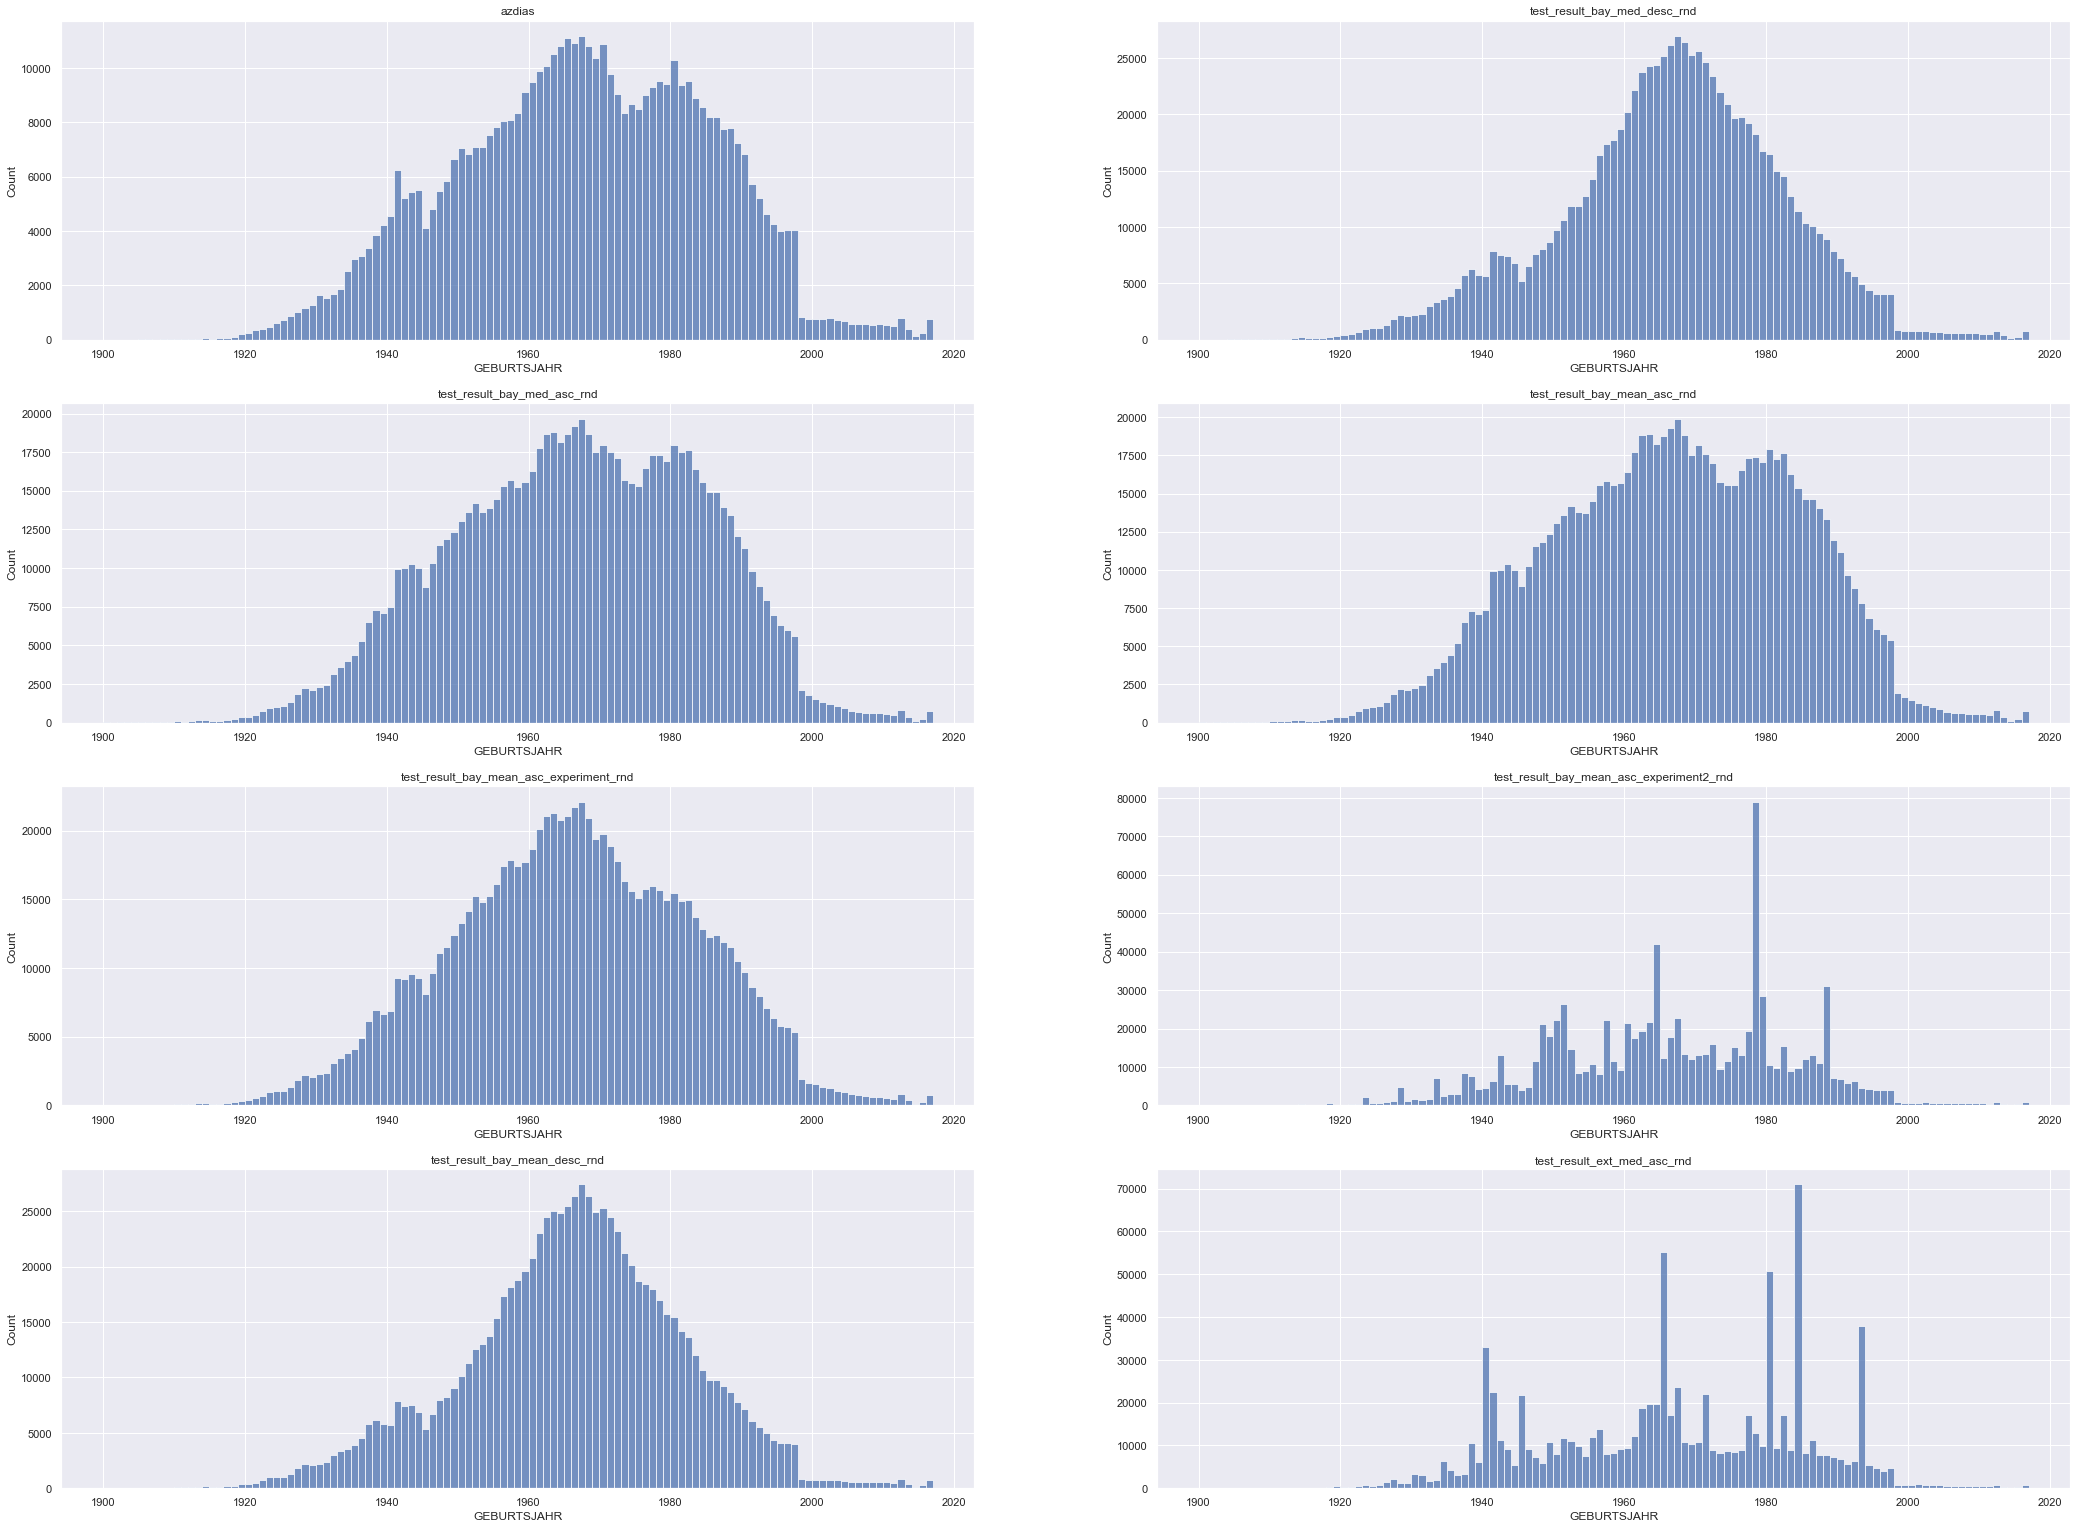

In [12]:
fig, axs = plt.subplots(4,2 , figsize=(12*3,9*3))

sns.histplot(azdias['GEBURTSJAHR'],bins=117,ax=axs[0][0])
axs[0][0].set_title(f'azdias')
sns.histplot(test_result_bay_med_desc_rnd['GEBURTSJAHR'].round(0),bins=117,ax=axs[0][1])
axs[0][1].set_title(f'test_result_bay_med_desc_rnd')
sns.histplot(test_result_bay_med_asc_rnd['GEBURTSJAHR'].round(0),bins=117,ax=axs[1][0])
axs[1][0].set_title(f'test_result_bay_med_asc_rnd')
sns.histplot(test_result_bay_mean_asc_rnd['GEBURTSJAHR'].round(0),bins=117,ax=axs[1][1])
axs[1][1].set_title(f'test_result_bay_mean_asc_rnd')
sns.histplot(test_result_bay_mean_asc_experiment_rnd['GEBURTSJAHR'].round(0),bins=117,ax=axs[2][0])
axs[2][0].set_title(f'test_result_bay_mean_asc_experiment_rnd')
sns.histplot(test_result_bay_mean_asc_experiment2_rnd['GEBURTSJAHR'].round(0),bins=117,ax=axs[2][1])
axs[2][1].set_title(f'test_result_bay_mean_asc_experiment2_rnd')
sns.histplot(test_result_bay_mean_desc_rnd['GEBURTSJAHR'].round(0),bins=117,ax=axs[3][0])
axs[3][0].set_title(f'test_result_bay_mean_desc_rnd')
sns.histplot(test_result_ext_med_asc_rnd['GEBURTSJAHR'].round(0),bins=117,ax=axs[3][1])
axs[3][1].set_title(f'test_result_ext_med_asc_rnd')

&rArr; The histograms of **Iterative Imputer (Bayesian ridge, imputation_order=ascending, initial_strategy=mean)** and
**Iterative Imputer (Bayesian ridge, imputation_order=ascending, initial_strategy=median)** apear to be closest to AZDIAS regarding shape

## Find the better of the two contenders (Bayesian ridge, ascending, mean vs. median)
Candidates:
* **Iterative Imputer (Bayesian ridge, imputation_order=ascending, initial_strategy=mean)**
* **Iterative Imputer (Bayesian ridge, imputation_order=ascending, initial_strategy=median)**

&rArr; So the difference between the candidates is the *initial_strategy* parameter *'mean vs. median'*

In [13]:
def prepare_data_for_plot_hists(df_before_imputation, df_after_imputation, column_name='GEBURTSJAHR', use_proprtions=True):
    df_before_imputation_vcounts = df_before_imputation[column_name].value_counts()
    df_after_imputation_vcounts = df_after_imputation[column_name].value_counts()
    combined_index = df_before_imputation_vcounts.sort_values().combine(
                df_after_imputation_vcounts.sort_values(), max, fill_value=0
    ).keys()
    df = pd.DataFrame(index=combined_index)
    if use_proprtions:
        df['df_after_imputation'] = df.join(df_after_imputation_vcounts / df_after_imputation_vcounts.sum()).fillna(0)
        df['df_before_imputation'] = df.join(df_before_imputation_vcounts / df_before_imputation_vcounts.sum())[column_name].fillna(0)
    else:
        df['df_after_imputation'] = df.join(df_after_imputation_vcounts).fillna(0)
        df['df_before_imputation'] = df.join(df_before_imputation_vcounts)[column_name].fillna(0)
    return pd.melt(df.reset_index(), ['index'])

def label_as_str(label):
    return label if int(label) % 5 == 0 else ''

def diff_df(df_before_imputation, df_after_imputation, column_name='GEBURTSJAHR', use_proprtions=True):
    df_before_imputation_vcounts = df_before_imputation[column_name].value_counts()
    df_after_imputation_vcounts = df_after_imputation[column_name].value_counts()
    combined_index = df_before_imputation_vcounts.sort_values().combine(
                df_after_imputation_vcounts.sort_values(), max, fill_value=0
    ).keys()
    df = pd.DataFrame(index=combined_index)
    if use_proprtions:
        df['df_after_imputation'] = df.join(df_after_imputation_vcounts / df_after_imputation_vcounts.sum()).fillna(0)
        df['df_before_imputation'] = df.join(df_before_imputation_vcounts / df_before_imputation_vcounts.sum())[column_name].fillna(0)
    else:
        df['df_after_imputation'] = df.join(df_after_imputation_vcounts).fillna(0)
        df['df_before_imputation'] = df.join(df_before_imputation_vcounts)[column_name].fillna(0)
    df['diff'] = df['df_after_imputation'] - df['df_before_imputation']
    return df[['diff']]

### Compare sum of abs(differences to azdias)
#### compare proportions of diffs: azdias vs test_result_bay_mean_asc 

In [40]:
df = diff_df(azdias, test_result_bay_mean_asc, 'GEBURTSJAHR', use_proprtions=True)
df['diff'].abs().sum()

0.8802732431125389

#### compare proportions of diffs: azdias vs test_result_bay_med_asc 

In [39]:
df = diff_df(azdias, test_result_bay_med_asc, 'GEBURTSJAHR', use_proprtions=True)
df['diff'].abs().sum()

0.8803024165723206

#### compare absolute diffs: azdias vs test_result_bay_mean_asc 

In [47]:
df = diff_df(azdias, test_result_bay_mean_asc, 'GEBURTSJAHR', use_proprtions=False)
df['diff'].abs().sum()

392318.0

#### compare absolute diffs: azdias vs test_result_bay_med_asc 

In [46]:
df = diff_df(azdias, test_result_bay_med_asc, 'GEBURTSJAHR', use_proprtions=False)
df['diff'].abs().sum()

392318.0

&rArr; The median based imputer is slightly better regarding the diffs, but the difference is neglectible

&rArr; So the contenders are about the same regarding this criterion

 ## Compare Histograms
 ### Iterative Imputer (Bayesian ridge, imputation_order=ascending, initial_strategy=mean)

In [53]:
labels = ['GEBURTSJAHR after imputation', 'GEBURTSJAHR before imputation']

In [54]:
len([int(year) for year in test_result_bay_mean_asc_rnd['GEBURTSJAHR'].sort_values().unique() if not pd.isnull(year)])

118

In [59]:
xticklabels = [label_as_str(int(year)) for year in test_result_bay_mean_asc_rnd['GEBURTSJAHR'].sort_values().unique() if not pd.isnull(year)]

Text(0, 0.5, 'count')

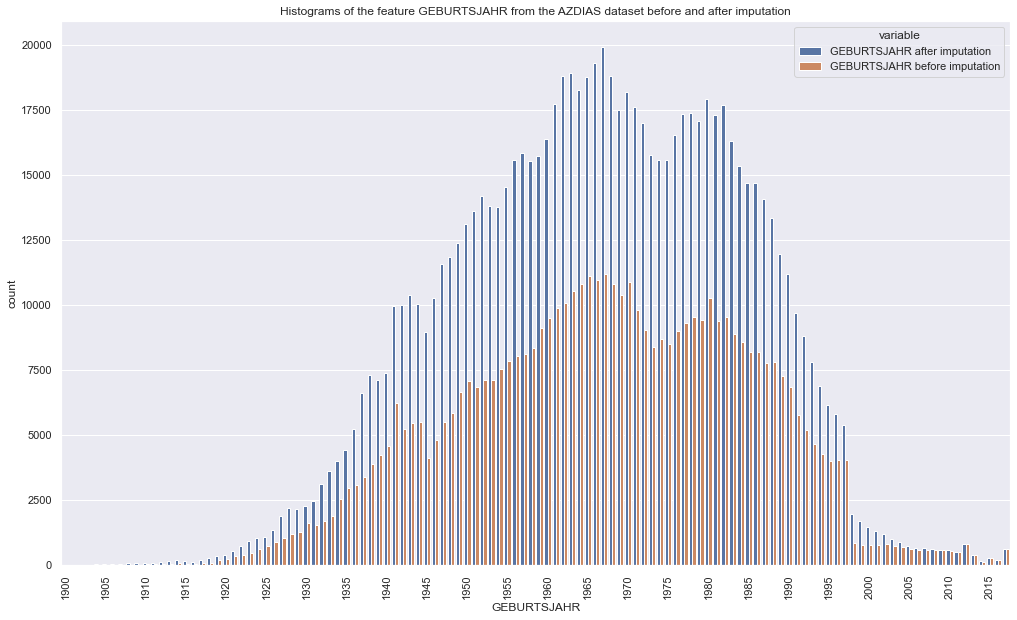

In [60]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (17, 10))
df = prepare_data_for_plot_hists(azdias, test_result_bay_mean_asc_rnd, 'GEBURTSJAHR', use_proprtions=False)
sns.barplot(data=df, x='index', y='value', hue='variable', ax=ax)
leg = ax.get_legend() # leg = g.axes.flat[0].get_legend()
for t, l in zip(leg.texts, labels): t.set_text(l)
ax.set_title(f"Histograms of the feature GEBURTSJAHR from the AZDIAS dataset before and after imputation")
ax.set_xlabel('GEBURTSJAHR')
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_ylabel('count')

### Iterative Imputer (Bayesian ridge, imputation_order=ascending, initial_strategy=median)

In [41]:
len([int(year) for year in test_result_bay_med_asc_rnd['GEBURTSJAHR'].sort_values().unique() if not pd.isnull(year)])

117

In [66]:
xticklabels = [label_as_str(int(year)) for year in test_result_bay_med_asc_rnd['GEBURTSJAHR'].sort_values().unique() if not pd.isnull(year)]

Text(0, 0.5, 'count')

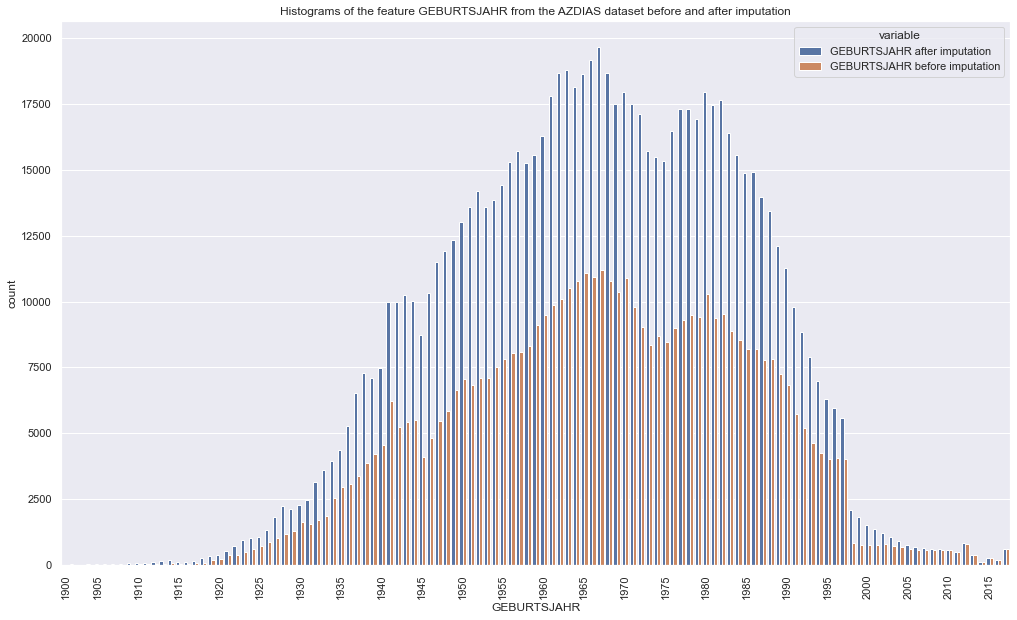

In [67]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (17, 10))
df = prepare_data_for_plot_hists(azdias, test_result_bay_med_asc_rnd, 'GEBURTSJAHR', use_proprtions=False)
sns.barplot(data=df, x='index', y='value', hue='variable', ax=ax)
leg = ax.get_legend() # leg = g.axes.flat[0].get_legend()
for t, l in zip(leg.texts, labels): t.set_text(l)
ax.set_title(f"Histograms of the feature GEBURTSJAHR from the AZDIAS dataset before and after imputation")
ax.set_xlabel('GEBURTSJAHR')
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_ylabel('count')

### Compare histograms of both imputers

In [70]:
xticklabels = [label_as_str(int(year)) for year in test_result_bay_mean_asc_rnd['GEBURTSJAHR'].sort_values().unique() if not pd.isnull(year)]
labels = ['initial_strategy=mean', 'initial_strategy=median']

Text(0, 0.5, 'count')

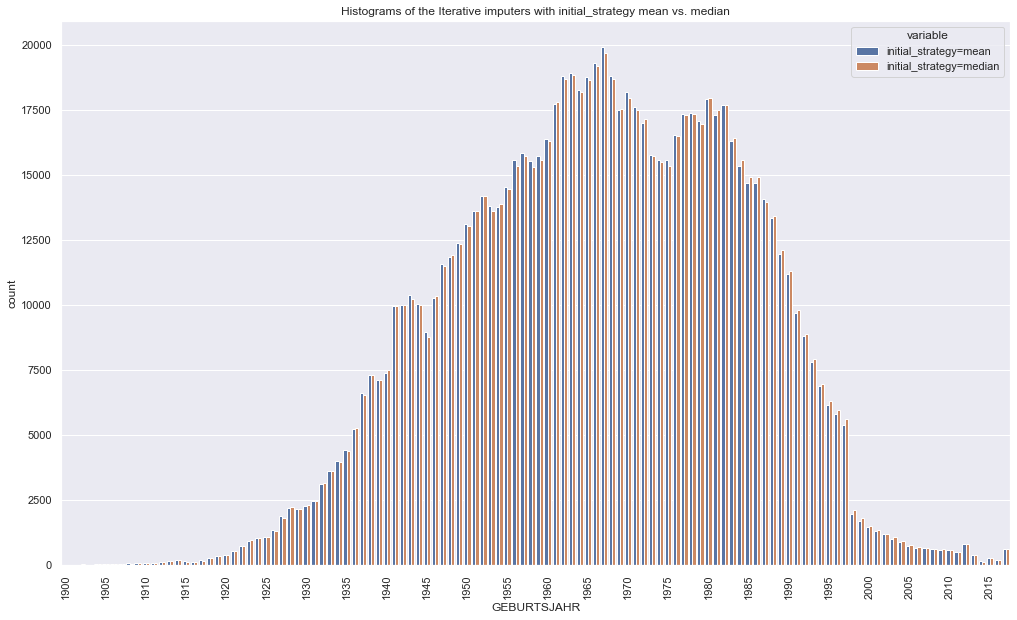

In [71]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize = (17, 10))
df = prepare_data_for_plot_hists(test_result_bay_med_asc_rnd, test_result_bay_mean_asc_rnd, 'GEBURTSJAHR', use_proprtions=False)
sns.barplot(data=df, x='index', y='value', hue='variable', ax=ax)
leg = ax.get_legend() # leg = g.axes.flat[0].get_legend()
for t, l in zip(leg.texts, labels): t.set_text(l)
ax.set_title(f"Histograms of the Iterative imputers with initial_strategy mean vs. median")
ax.set_xlabel('GEBURTSJAHR')
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_ylabel('count')

* The mean imputer shows a bit higher values for age groups born before 1980 than the median 

* The median imputer shows higher values for age groups born after 1980 than the mean

&rArr; **The two imputers are almost the same**

* We can use either

&rArr; after a few experiments I decided to use **IterativeImputer with estimator=BayesianRidge, imputation_order=ascending, initial_strategy=median)**